In [ ]:
#  Google Drive'ı bağlama
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


TEMİZLİK KURALLARI (Cleaning Rules)
Bu projede veriyi temizlemek için aşağıdaki kurallar uygulanmıştır:
1. `pickup_datetime` değeri NaT olan satırlar silindi.
2. `trip_duration` 60 saniyeden kısa ve 7200 saniyeden uzun olan kayıtlar silindi.
3. Koordinatları NYC sınırları dışında olan satırlar silindi:
   - Enlem: 40.5 ile 40.9 arası
   - Boylam: -74.25 ile -73.7 arası
4. `passenger_count` değeri 1 ile 6 arasında olmayan satırlar silindi.
5. (İsteğe bağlı) IQR yöntemine göre aşırı uç değerler incelendi.


In [ ]:
# Gerekli kütüphanelerin kurulması ve import edilmesi
!pip install folium --quiet
!pip install seaborn --quiet


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

#  Grafiklerin Colab içinde gösterimi
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,5)
sns.set(style="whitegrid")


 CSV’den hızlı ön izleme için örnek veri okuma

Bu hücre, Google Drive’dan train.csv dosyasını okur.
Sadece ilk 1000 satır alınır.
Shape ve ilk 5 satır gösterilir.
Amacı: veri yapısını ve sütunları hızlıca anlamak.
# New Section

In [ ]:
# Buraya Drive'daki dosya yolunuzu koyun
path = '/content/drive/MyDrive/train.csv'  # Yol farklıysa değiştirin

# Hızlı ön izleme için sadece ilk 1000 satırı okuyalım
df_sample = pd.read_csv(path, nrows=1000)
print("Sample loaded. shape:", df_sample.shape)
display(df_sample.head())


Sample loaded. shape: (1000, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
df = pd.read_csv(path, low_memory=False)
print("Full dataframe loaded. shape:", df.shape)


Full dataframe loaded. shape: (1458644, 11)


 Veriye genel bakış (Overview)

- İlk 5 satır görüntülenir (head())
- Veri tipleri ve eksik değerler info() ile kontrol edilir
- Sayısal sütunlar describe() ile özetlenir
Amacı: veri yapısını ve temel istatistikleri anlamak.


In [ ]:

display(df.head())
print("\nINFO:\n")
df.info()
print("\nDESCRIBE (numerical):\n")
display(df.describe().T)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435



INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB

DESCRIBE (numerical):



,count,mean,std,min,25%,50%,75%,max
vendor_id,1458644.0,1.534950,0.498777,1.000000,1.000000,2.000000,2.000000,2.000000e+00
passenger_count,1458644.0,1.664530,1.314242,0.000000,1.000000,1.000000,2.000000,9.000000e+00
pickup_longitude,1458644.0,-73.973486,0.070902,-121.933342,-73.991867,-73.981743,-73.967331,-6.133553e+01
pickup_latitude,1458644.0,40.750921,0.032881,34.359695,40.737347,40.754101,40.768360,5.188108e+01
dropoff_longitude,1458644.0,-73.973416,0.070643,-121.933304,-73.991325,-73.979752,-73.963013,-6.133553e+01
dropoff_latitude,1458644.0,40.751800,0.035891,32.181141,40.735885,40.754524,40.769810,4.392103e+01
trip_duration,1458644.0,959.492273,5237.431724,1.000000,397.000000,662.000000,1075.000000,3.526282e+06


 pickup_datetime sütununu datetime’a çevirme ve zaman özellikleri çıkarma

- pickup_datetime datetime türüne çevrilir
- Saat (hour), hafta günü (weekday), ay (month), hafta sonu (is_weekend) sütunları oluşturulur
Amacı: zamana bağlı analizler için yeni sütunlar eklemek.


In [ ]:
# Sütunu datetime tipine çevir (eğer object tipindeyse)
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')

# Temel zaman özelliklerini oluştur
df['hour'] = df['pickup_datetime'].dt.hour
df['weekday'] = df['pickup_datetime'].dt.dayofweek
df['month'] = df['pickup_datetime'].dt.month
df['is_weekend'] = df['weekday'].isin([5,6]).astype(int)
df[['pickup_datetime','hour','weekday','month','is_weekend']].head()


,pickup_datetime,hour,weekday,month,is_weekend
0,2016-03-14 17:24:55,17,0,3,0
1,2016-06-12 00:43:35,0,6,6,1
2,2016-01-19 11:35:24,11,1,1,0
3,2016-04-06 19:32:31,19,2,4,0
4,2016-03-26 13:30:55,13,5,3,1


 trip_duration dağılım analizi

- Histogram: linear ve log1p ölçeklerinde
- Temel istatistiksel ölçümler (quantiles) hesaplanır
Amacı: trip_duration dağılımını anlamak ve olası uç değerleri görmek.


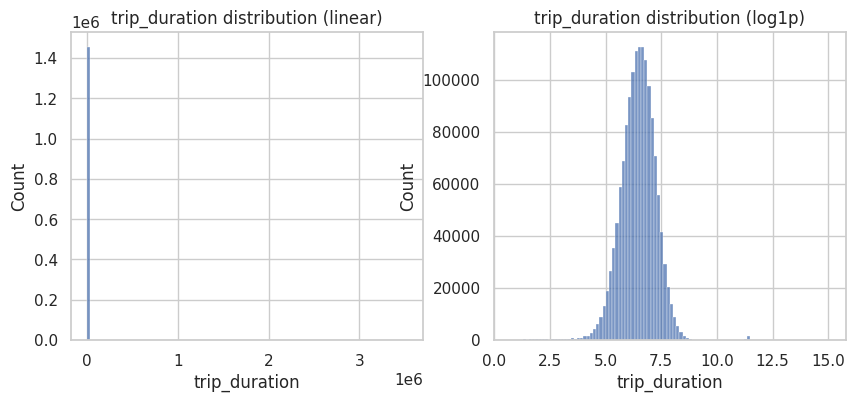

0.00          1.0
0.01         87.0
0.25        397.0
0.50        662.0
0.75       1075.0
0.99       3440.0
1.00    3526282.0
Name: trip_duration, dtype: float64


In [ ]:
# Eğer değilse saniye cinsine çevir, ardından küçük bir histogram çiz (log ölçeği uzun kuyruk için)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(df['trip_duration'].dropna(), bins=100)
plt.title('trip_duration distribution (linear)')
plt.subplot(1,2,2)
sns.histplot(np.log1p(df['trip_duration'].dropna()), bins=100)
plt.title('trip_duration distribution (log1p)')
plt.show()

# Basit istatistikler
print(df['trip_duration'].quantile([0,0.01,0.25,0.5,0.75,0.99,1.0]))


 Pickup ve Dropoff noktaları arasındaki mesafeyi hesaplama (Haversine formülü)

- Girişler Series veya numpy array olabilir
- Çıktı kilometre cinsindendir
- haversine_km adında yeni sütun eklenir
Amacı: her yolculuk için mesafe bilgisini elde etmek ve analizlerde kullanmak.


In [ ]:
def haversine_np(lat1, lon1, lat2, lon2):
    """
    Girişler numpy array veya Series olabilir; sonuç kilometre cinsindendir
    """
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km

# İlk satırlar üzerinde hızlı test
df['haversine_km'] = haversine_np(df['pickup_latitude'], df['pickup_longitude'],
                                  df['dropoff_latitude'], df['dropoff_longitude'])
df[['haversine_km']].head()


,haversine_km
0,1.498521
1,1.805507
2,6.385098
3,1.485498
4,1.188588


 Temel veri temizleme adımları

- pickup_datetime eksik olan satırlar silinir
- trip_duration mantıksız değerler (<60 veya >7200) silinir
- NYC sınırları dışındaki koordinatlar temizlenir
- passenger_count 1–6 aralığında olmalı
Amacı: analiz ve modelleme için temiz bir veri seti oluşturmak.


In [ ]:
# Temel filtreleme denemesi için kopya
df_clean = df.copy()

# 1) pickup_datetime okunamayan satırları sil
df_clean = df_clean[df_clean['pickup_datetime'].notna()]

# 2) Mantıksız trip_duration değerlerini kaldır
df_clean = df_clean[(df_clean['trip_duration'] >= 60) & (df_clean['trip_duration'] <= 7200)]

# 3) NYC coğrafi sınırları (örnek: Manhattan + NYC’nin bazı kısımları)
df_clean = df_clean[(df_clean['pickup_latitude'].between(40.5,40.9)) &
                    (df_clean['pickup_longitude'].between(-74.25,-73.7))]

# 4) Mantıklı passenger_count değerleri
df_clean = df_clean[df_clean['passenger_count'].between(1,6)]

print("After cleaning shape:", df_clean.shape)
df_clean.head()


After cleaning shape: (1447628, 16)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,hour,weekday,month,is_weekend,haversine_km
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,0,3,0,1.498521
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,6,6,1,1.805507
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,1,1,0,6.385098
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19,2,4,0,1.485498
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13,5,3,1,1.188588


In [ ]:
# Temizlik özeti: temizlemeden önce ve sonra satır sayısı
print("Ham veri boyutu:", df.shape)
print("Temizlenmiş veri boyutu:", df_clean.shape)
silinen = df.shape[0] - df_clean.shape[0]
oran = 100 * silinen / df.shape[0]
print("Silinen satır sayısı:", silinen)
print("Silinen oran (%):", round(oran, 2))


Ham veri boyutu: (1458644, 16)
Temizlenmiş veri boyutu: (1447628, 16)
Silinen satır sayısı: 11016
Silinen oran (%): 0.76


 Temizlik sonrası sütunların kontrolü

- Sütun sayısı ve isimleri yazdırılır
Amacı: tüm sütunların mevcut ve analiz için hazır olduğundan emin olmak.


In [ ]:
# Mevcut sütun isimlerini ve sayısını göster
print("Sütun sayısı:", len(df_clean.columns))
print(df_clean.columns)


Sütun sayısı: 16
Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'hour', 'weekday', 'month', 'is_weekend',
       'haversine_km'],
      dtype='object')


In [ ]:
#  Eksik Değer Analizi
# Bu hücre her sütundaki eksik (NaN) değer sayısını gösterir.
# Veri temizliği ve analiz öncesi eksik değerlerin tespiti için kullanılır.
print(" Her sütundaki eksik değer sayısı:\n")
print(df_clean.isnull().sum())


 Her sütundaki eksik değer sayısı:

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
hour                  0
weekday               0
month                 0
is_weekend            0
haversine_km          0
dtype: int64


 Outlier / Aykırı Değer Temizleme

Bu hücre, 'trip_duration' değerlerini 60 ile 7200 saniye arasında tutarak aşırı uç değerleri temizler.
Ayrıca, 'distance_km' sütunu varsa çok küçük veya çok büyük değerler silinir.
Bu adım, analiz ve modelleme için daha güvenilir veri sağlar.


In [ ]:
# trip_duration sütunundaki aykırı değerleri kaldır
df_clean = df_clean[(df_clean['trip_duration'] > 60) & (df_clean['trip_duration'] < 7200)]

# Eğer distance_km sütunu varsa, aşırı değerleri kaldır (isteğe bağlı)
if 'distance_km' in df_clean.columns:
    df_clean = df_clean[(df_clean['distance_km'] > 0.2) & (df_clean['distance_km'] < 50)]

print("Aykırı değerler kaldırıldıktan sonra şekil:", df_clean.shape)


Aykırı değerler kaldırıldıktan sonra şekil: (1447454, 16)


 Zaman Özellikleri

'pickup_datetime' sütunu datetime türüne çevrilir ve yeni sütunlar eklenir:
- pickup_date: tarih
- pickup_hour: saat
- pickup_dayofweek: haftanın günü
Bu sayede zaman bazlı analizler yapılabilir.


In [ ]:
# pickup_datetime sütununu datetime formatına çevir
df_clean['pickup_datetime'] = pd.to_datetime(df_clean['pickup_datetime'])

# Zaman özelliklerini çıkar
df_clean['pickup_date'] = df_clean['pickup_datetime'].dt.date
df_clean['pickup_hour'] = df_clean['pickup_datetime'].dt.hour
df_clean['pickup_dayofweek'] = df_clean['pickup_datetime'].dt.dayofweek


 Mesafe Hesaplama (Haversine Formülü)

Bu hücre, iki koordinat arasındaki mesafeyi kilometre cinsinden hesaplar.
Eğer 'distance_km' sütunu yoksa oluşturulur.
Bu özellik, trip süresi ve mesafe ilişkisini analiz etmek için önemlidir.


In [ ]:
import numpy as np

# Küresel mesafeyi hesaplayan fonksiyon (Haversine formülü)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Dünyanın yarıçapı kilometre cinsinden
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

# distance_km sütunu yoksa oluştur
if 'distance_km' not in df_clean.columns:
    df_clean['distance_km'] = haversine(df_clean['pickup_latitude'],
                                        df_clean['pickup_longitude'],
                                        df_clean['dropoff_latitude'],
                                        df_clean['dropoff_longitude'])

print("distance_km sütunu başarıyla eklendi.")


distance_km sütunu başarıyla eklendi.


 Temiz Veri Seti ve İstatistikler

Temizlik ve hazırlık sonrası veri setinin boyutu görüntülenir.
Ayrıca, trip_duration dağılımı log ölçekle gösterilir.
Bu adım, verinin genel özelliklerini ve dağılımını anlamak için önemlidir.


In [ ]:
print("Temizlik ve ön hazırlık sonrası veri setinin boyutu:", df_clean.shape)
df_clean.head()


Temizlik ve ön hazırlık sonrası veri setinin boyutu: (1447454, 20)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,hour,weekday,month,is_weekend,haversine_km,pickup_date,pickup_hour,pickup_dayofweek,distance_km
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,0,3,0,1.498521,2016-03-14,17,0,1.498521
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,6,6,1,1.805507,2016-06-12,0,6,1.805507
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,1,1,0,6.385098,2016-01-19,11,1,6.385098
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19,2,4,0,1.485498,2016-04-06,19,2,1.485498
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13,5,3,1,1.188588,2016-03-26,13,5,1.188588


 Veri setinin boyutu: (1447628, 16)


,count,mean,min,25%,50%,75%,max,std
vendor_id,1447628.0,1.535053,1.0,1.0,2.0,2.0,2.0,0.49877
pickup_datetime,1447628,2016-04-01 09:54:44.310066176,2016-01-01 00:00:17,2016-02-17 16:29:49.249999872,2016-04-01 16:48:16.500000,2016-05-15 03:30:57.750000128,2016-06-30 23:59:39,NaN
passenger_count,1447628.0,1.66537,1.0,1.0,1.0,2.0,6.0,1.314684
pickup_longitude,1447628.0,-73.973581,-74.23378,-73.991875,-73.981766,-73.96743,-73.704918,0.037794
pickup_latitude,1447628.0,40.75099,40.506294,40.737411,40.754135,40.768364,40.89941,0.027869
dropoff_longitude,1447628.0,-73.973492,-79.817978,-73.991325,-73.979774,-73.963104,-70.346077,0.037121
dropoff_latitude,1447628.0,40.751874,36.398121,40.735947,40.754559,40.769825,43.921028,0.032741
trip_duration,1447628.0,840.893722,60.0,401.0,665.0,1076.0,7191.0,653.23102
hour,1447628.0,13.61199,0.0,9.0,14.0,19.0,23.0,6.396863
weekday,1447628.0,3.04952,0.0,1.0,3.0,5.0,6.0,1.953774


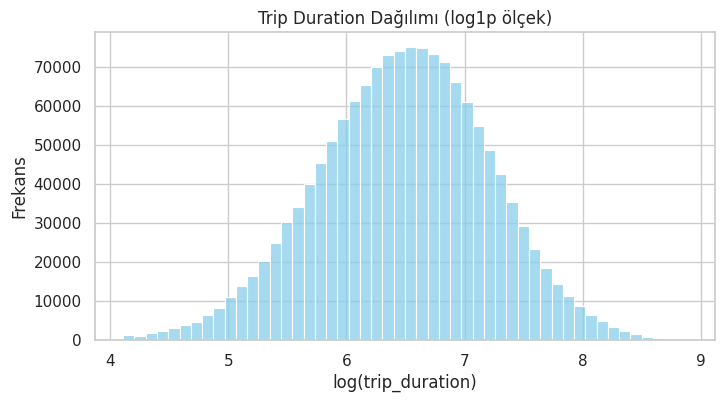

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="pastel")

print(" Veri setinin boyutu:", df_clean.shape)
display(df_clean.describe().T)

# Trip duration dağılımı (log ölçek)
plt.figure(figsize=(8,4))
sns.histplot(np.log1p(df_clean['trip_duration']), bins=50, color='skyblue')
plt.title("Trip Duration Dağılımı (log1p ölçek)")
plt.xlabel("log(trip_duration)")
plt.ylabel("Frekans")
plt.show()


 Saat ve Gün Bazlı Analiz

Trip sürelerinin saatlere ve haftanın günlerine göre dağılımını gösterir.
Boxplotlar ile log(trip_duration) dağılımı görselleştirilir.
Zaman bazlı trendleri ve yoğun saatleri gözlemlemeye yardımcı olur.


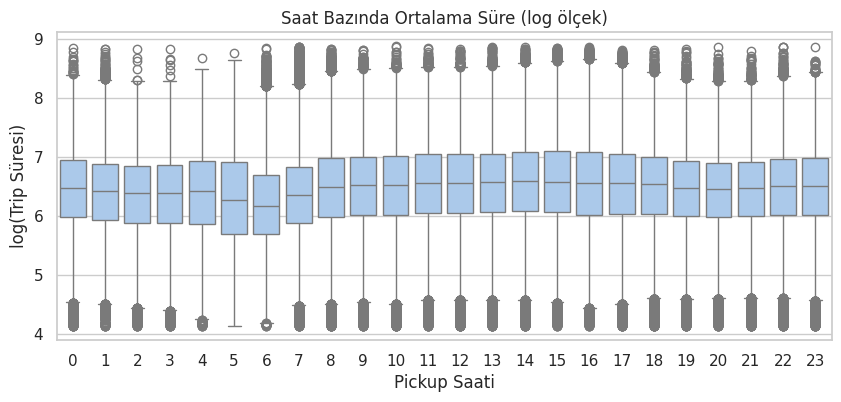

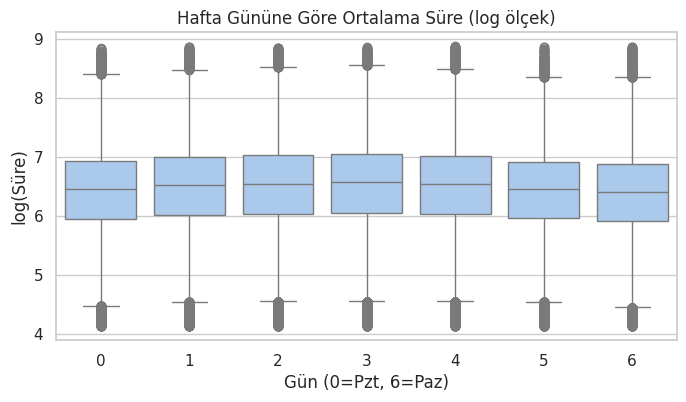

In [ ]:
# Ortalama süreye göre saatlik analiz
plt.figure(figsize=(10,4))
sns.boxplot(x='pickup_hour', y=np.log1p(df_clean['trip_duration']), data=df_clean)
plt.title("Saat Bazında Ortalama Süre (log ölçek)")
plt.xlabel("Pickup Saati")
plt.ylabel("log(Trip Süresi)")
plt.show()

# Hafta gününe göre
plt.figure(figsize=(8,4))
sns.boxplot(x='pickup_dayofweek', y=np.log1p(df_clean['trip_duration']), data=df_clean)
plt.title("Hafta Gününe Göre Ortalama Süre (log ölçek)")
plt.xlabel("Gün (0=Pzt, 6=Paz)")
plt.ylabel("log(Süre)")
plt.show()


 Mesafe ve Yolcu Sayısı Etkisi

- Scatterplot ile mesafe ile trip süresi ilişkisi gösterilir.
- Boxplot ile yolcu sayısına göre trip süreleri incelenir.
Bu analizler, temel değişkenlerin trip süresine etkisini anlamaya yarar.


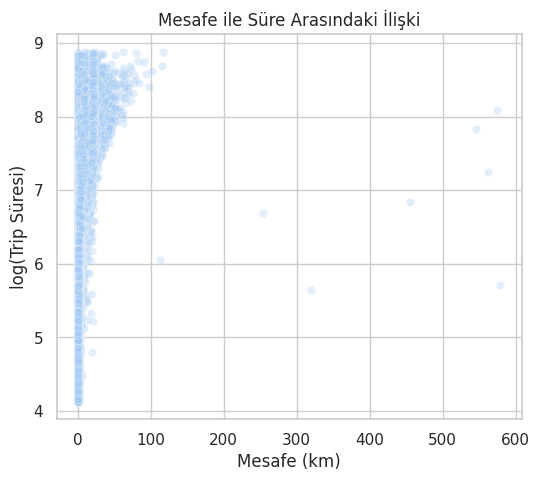

In [ ]:
plt.figure(figsize=(6,5))
sns.scatterplot(x='distance_km', y=np.log1p(df_clean['trip_duration']), data=df_clean, alpha=0.3)
plt.title("Mesafe ile Süre Arasındaki İlişki")
plt.xlabel("Mesafe (km)")
plt.ylabel("log(Trip Süresi)")
plt.show()


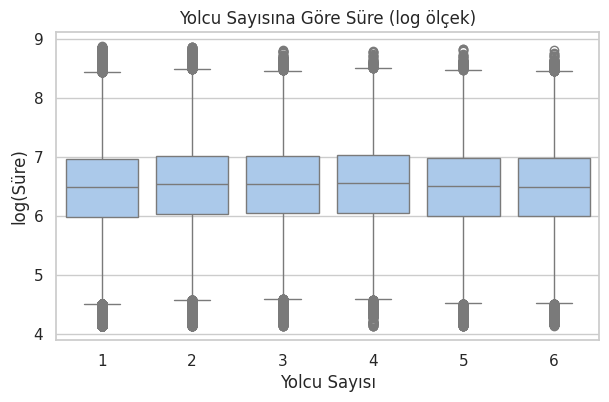

In [ ]:
plt.figure(figsize=(7,4))
sns.boxplot(x='passenger_count', y=np.log1p(df_clean['trip_duration']), data=df_clean)
plt.title("Yolcu Sayısına Göre Süre (log ölçek)")
plt.xlabel("Yolcu Sayısı")
plt.ylabel("log(Süre)")
plt.show()


Heatmap ile Coğrafi Yoğunluk

Pickup noktalarının yoğunluk haritası oluşturulur.
5000 örnek kullanılarak Manhattan civarı için görselleştirme yapılır.
Yoğun bölgeleri hızlıca görmemizi sağlar.


In [ ]:
from folium.plugins import HeatMap
import folium

m = folium.Map(location=[40.75, -73.97], zoom_start=11)
heat_data = df_clean[['pickup_latitude', 'pickup_longitude']].dropna().sample(5000)
HeatMap(heat_data).add_to(m)
m


 Outlier / Aykırı Değer Analizi (IQR)

Trip duration için IQR yöntemi ile uç değerler hesaplanır.
Alt ve üst sınırlar belirlenir, hangi değerlerin outlier olduğu sayısal olarak gösterilir.
Boxplot ile görselleştirilir.


In [ ]:
# Uç değer analizi (Outlier incelemesi)
Q1 = df_clean['trip_duration'].quantile(0.25)
Q3 = df_clean['trip_duration'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_clean[(df_clean['trip_duration'] < lower_bound) | (df_clean['trip_duration'] > upper_bound)]
outlier_count = outliers.shape[0]
outlier_ratio = (outlier_count / df_clean.shape[0]) * 100

print(" IQR:", IQR)
print(" Alt sınır (Lower Bound):", lower_bound)
print(" Üst sınır (Upper Bound):", upper_bound)
print(" Uç değer sayısı:", outlier_count)
print(" Veri içindeki oranı: %.2f%%" % outlier_ratio)


 IQR: 675.0
 Alt sınır (Lower Bound): -611.5
 Üst sınır (Upper Bound): 2088.5
 Uç değer sayısı: 72360
 Veri içindeki oranı: 5.00%


### Karar: Final Veri Kümesi - `df_clean`
- `df_clean`: 60–7200 saniye arası yolculuk süresi filtresi, NYC koordinat filtresi ve yolcu sayısı (1–6) filtresi uygulanmış veri kümesi.
- `df_no_outliers`: IQR yöntemi ile uç değerlerin çıkarıldığı ek bir versiyon.
 Modelleme için **ana veri kümesi olarak `df_clean` kullanılacaktır**.


In [ ]:
# Grup çalışması için final veri kümesini belirleme
final_df = df_clean.copy()
print("Final veri kümesi boyutu:", final_df.shape)
final_df.head()


Final veri kümesi boyutu: (1447628, 16)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,hour,weekday,month,is_weekend,haversine_km
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,0,3,0,1.498521
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,6,6,1,1.805507
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,1,1,0,6.385098
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19,2,4,0,1.485498
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13,5,3,1,1.188588


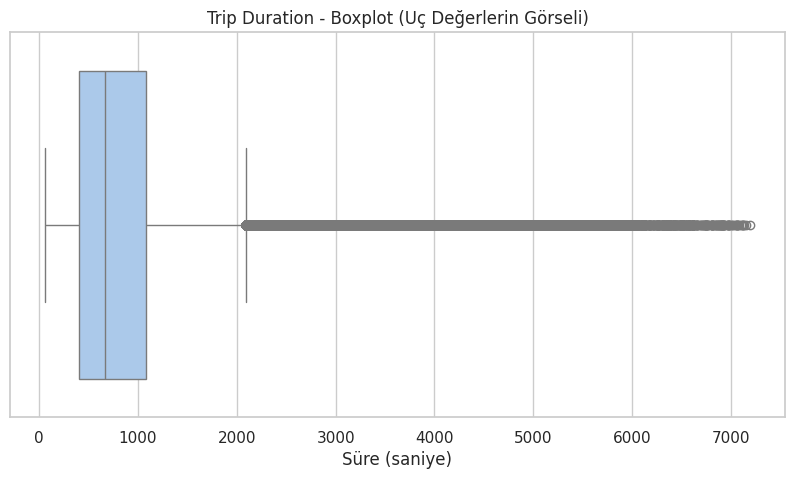

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df_clean['trip_duration'])
plt.title("Trip Duration - Boxplot (Uç Değerlerin Görseli)")
plt.xlabel("Süre (saniye)")
plt.show()


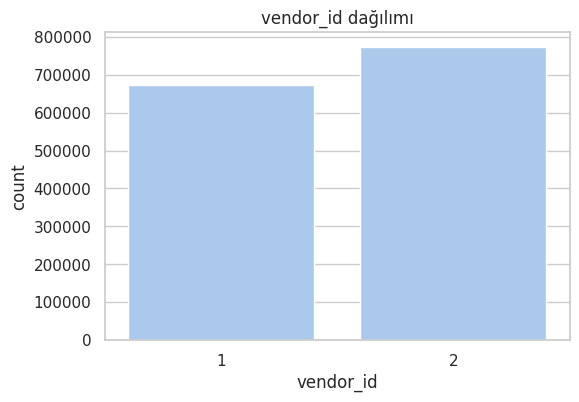

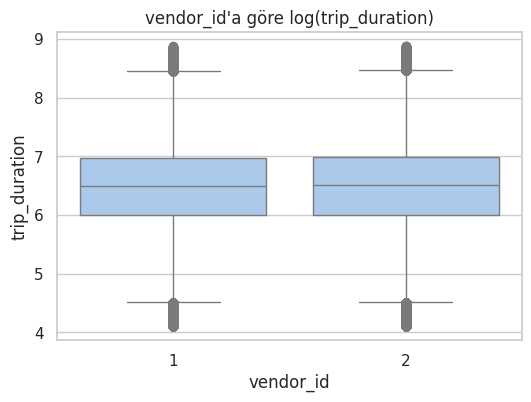

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='vendor_id', data=df_clean)
plt.title('vendor_id dağılımı')
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x='vendor_id', y=np.log1p(df_clean['trip_duration']), data=df_clean)
plt.title("vendor_id'a göre log(trip_duration)")
plt.show()


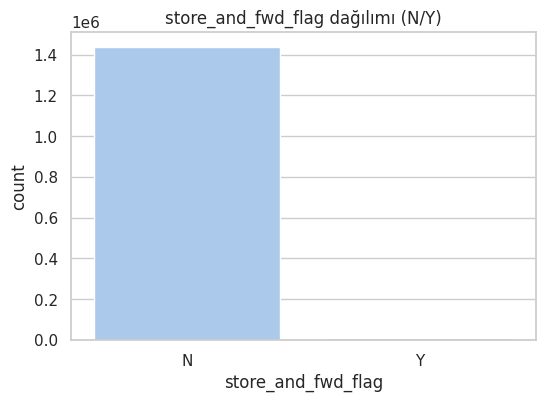

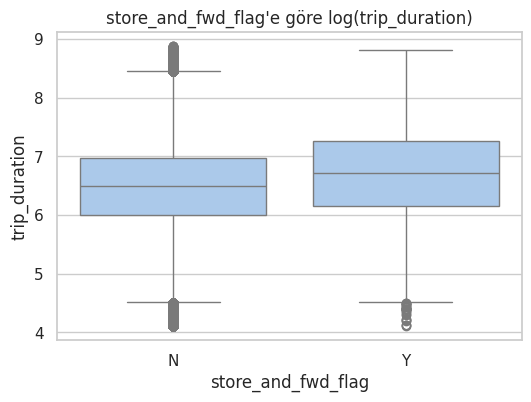

In [ ]:
# store_and_fwd_flag (N/Y) analizi ve süresiyle ilişkisi
plt.figure(figsize=(6,4))
sns.countplot(x='store_and_fwd_flag', data=df_clean)
plt.title('store_and_fwd_flag dağılımı (N/Y)')
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x='store_and_fwd_flag', y=np.log1p(df_clean['trip_duration']), data=df_clean)
plt.title("store_and_fwd_flag'e göre log(trip_duration)")
plt.show()


 Outlier Temizlenmiş Veri Seti

IQR yöntemi ile belirlenen uç değerler çıkarıldıktan sonra yeni veri seti oluşturulur.
Yeni boyut ve silinen satır sayısı görüntülenir.
Bu set modelleme için kullanıma hazırdır.


In [ ]:
# Uç değerlerin kaldırılması (Removing outliers)
df_no_outliers = df_clean[(df_clean['trip_duration'] >= lower_bound) &
                          (df_clean['trip_duration'] <= upper_bound)]

print("Uç değerler çıkarıldıktan sonraki veri setinin boyutu:", df_no_outliers.shape)
print("Silinen değer sayısı:", df_clean.shape[0] - df_no_outliers.shape[0])


Uç değerler çıkarıldıktan sonraki veri setinin boyutu: (1375094, 20)
Silinen değer sayısı: 72360


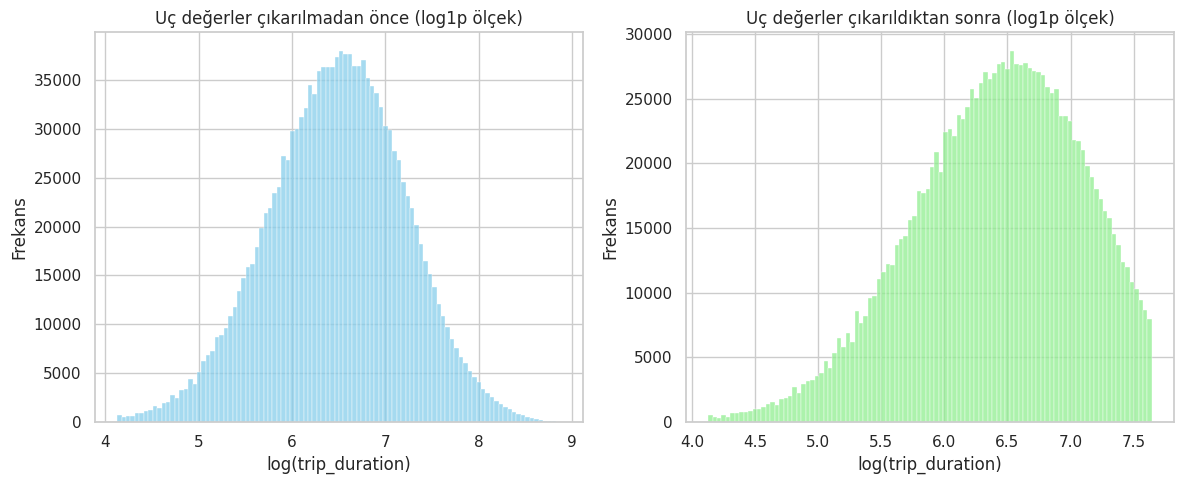

In [ ]:
# Temizlikten önce ve sonra yolculuk süresi dağılımı
plt.figure(figsize=(12,5))

# Uç değerler çıkarılmadan önce
plt.subplot(1,2,1)
sns.histplot(np.log1p(df_clean['trip_duration']), bins=100, color='skyblue')
plt.title("Uç değerler çıkarılmadan önce (log1p ölçek)")
plt.xlabel("log(trip_duration)")
plt.ylabel("Frekans")

# Uç değerler çıkarıldıktan sonra
plt.subplot(1,2,2)
sns.histplot(np.log1p(df_no_outliers['trip_duration']), bins=100, color='lightgreen')
plt.title("Uç değerler çıkarıldıktan sonra (log1p ölçek)")
plt.xlabel("log(trip_duration)")
plt.ylabel("Frekans")

plt.tight_layout()
plt.show()


 Gün ve Saat Bazlı Trip Analizi

- Saatlere göre toplam trip sayısı
- Haftanın günlerine göre trip süresi boxplot
Bu adımlar, zaman bazlı yoğunluk ve performans analizi sağlar.


In [ ]:
# pickup_datetime sütununu datetime türüne dönüştürme

df_no_outliers = df_no_outliers.copy()

df_no_outliers['pickup_datetime'] = pd.to_datetime(df_no_outliers['pickup_datetime'])


# Zaman özelliklerini çıkarma
df_no_outliers['hour'] = df_no_outliers['pickup_datetime'].dt.hour
df_no_outliers['day_of_week'] = df_no_outliers['pickup_datetime'].dt.dayofweek
df_no_outliers['month'] = df_no_outliers['pickup_datetime'].dt.month

# Haftanın günlerini haritalama
days_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
df_no_outliers['day_name'] = df_no_outliers['day_of_week'].map(days_map)

df_no_outliers[['pickup_datetime', 'hour', 'day_name', 'month']].head()


,pickup_datetime,hour,day_name,month
0,2016-03-14 17:24:55,17,Mon,3
1,2016-06-12 00:43:35,0,Sun,6
3,2016-04-06 19:32:31,19,Wed,4
4,2016-03-26 13:30:55,13,Sat,3
5,2016-01-30 22:01:40,22,Sat,1


/tmp/ipython-input-1974774808.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hour', data=df_no_outliers, palette='viridis')


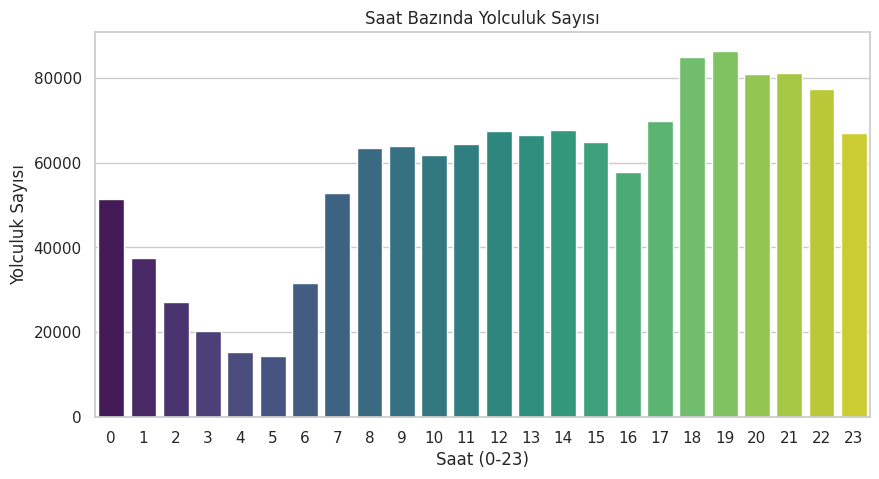

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='hour', data=df_no_outliers, palette='viridis')
plt.title("Saat Bazında Yolculuk Sayısı")
plt.xlabel("Saat (0-23)")
plt.ylabel("Yolculuk Sayısı")
plt.show()


/tmp/ipython-input-1576029771.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='day_name', y='trip_duration', data=df_no_outliers, palette='coolwarm')


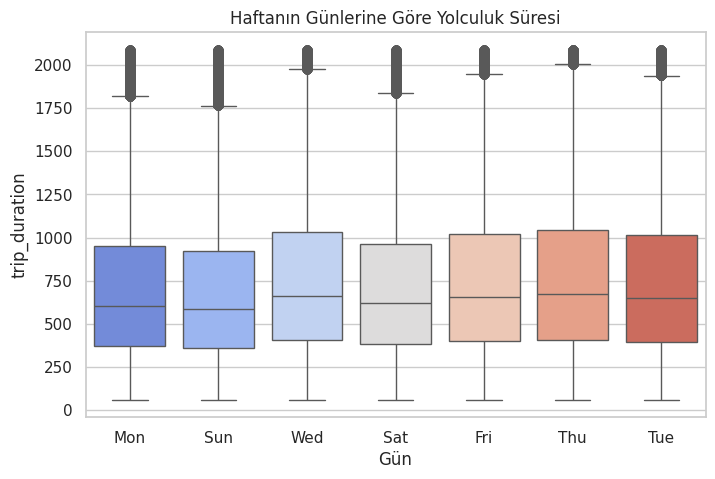

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='day_name', y='trip_duration', data=df_no_outliers, palette='coolwarm')
plt.title("Haftanın Günlerine Göre Yolculuk Süresi")
plt.xlabel("Gün")
plt.ylabel("trip_duration")
plt.show()


 Hotspots Analizi

- Pickup noktaları 3 ondalık basamağa yuvarlanır (~100m hassasiyet)
- Her noktada toplam trip sayısı ve ortalama süre hesaplanır
- En yoğun 10 nokta görüntülenir
Bu adım, şehirdeki yoğun bölgeleri belirlemeye yarar.


In [ ]:
# ===== Hücre 1: Hızlı Hazırlıklar (Güvenli kopya + koordinat yuvarlama ile hotspots çıkarma) =====
df_geo = df_no_outliers.copy()  # SettingWithCopyWarning önlemek için kopya

# Koordinatları üç ondalık basamağa yuvarla ~ yaklaşık 100 metre hassasiyet (isteğe bağlı değiştirilebilir)
df_geo['p_lat_r'] = df_geo['pickup_latitude'].round(3)
df_geo['p_lon_r'] = df_geo['pickup_longitude'].round(3)

# Hızlı toplama: her "coğrafi hücre" için yolculuk sayısı ve ortalama süre
hotspots = df_geo.groupby(['p_lat_r','p_lon_r']).agg(
    trips=('id','count'),
    avg_duration_s=('trip_duration','mean')
).reset_index().sort_values('trips', ascending=False)

# En yoğun 10 noktayı göster
hotspots_top10 = hotspots.head(10)
hotspots_top10


,p_lat_r,p_lon_r,trips,avg_duration_s
6872,40.751,-73.994,8390,840.424553
6788,40.750,-73.991,7515,777.378443
9063,40.774,-73.873,6143,1344.169950
6787,40.750,-73.992,5972,777.270764
9065,40.774,-73.871,4742,1346.201181
7454,40.757,-73.990,4202,667.362922
7357,40.756,-73.991,3965,689.490038
6976,40.752,-73.978,3860,795.832642
8461,40.768,-73.982,3535,682.341443
6875,40.751,-73.991,3395,687.066274


 Hotspots Sonuçlarının Kaydedilmesi

En yoğun 10 pickup noktası / csv dosyası olarak kaydedilir.
Raporlama ve paylaşım için kullanılabilir.


In [ ]:
# ===== Hücre 2: Sonuçları kaydetme / raporlama =====
hotspots_top10.to_csv('/content/hotspots_top10.csv', index=False)
print("Kaydedildi: /content/hotspots_top10.csv — En yoğun 10 hotspot.")
display(hotspots_top10)


Kaydedildi: /content/hotspots_top10.csv — En yoğun 10 hotspot.


,p_lat_r,p_lon_r,trips,avg_duration_s
6872,40.751,-73.994,8390,840.424553
6788,40.750,-73.991,7515,777.378443
9063,40.774,-73.873,6143,1344.169950
6787,40.750,-73.992,5972,777.270764
9065,40.774,-73.871,4742,1346.201181
7454,40.757,-73.990,4202,667.362922
7357,40.756,-73.991,3965,689.490038
6976,40.752,-73.978,3860,795.832642
8461,40.768,-73.982,3535,682.341443
6875,40.751,-73.991,3395,687.066274


 HeatMap Örneği (50000 Örnek)

Manhattan civarında pickup noktalarının yoğunluk haritası.
Colab üzerinde interaktif olarak gösterilir.
# New Section

In [ ]:
# ===== Hücre 3: Örnekleme ile hızlı HeatMap =====
from folium.plugins import HeatMap
import folium

# Harita merkezini yaklaşık olarak Manhattan belirleyelim
m = folium.Map(location=[40.75, -73.97], zoom_start=11)

# Veri küçükse 50000 veya daha az örnek alıyoruz
sample_for_map = df_geo[['pickup_latitude','pickup_longitude']].dropna().sample(n=min(50000, len(df_geo)), random_state=42)
heat_data = sample_for_map.values.tolist()

# HeatMap'i oluştur ve haritaya ekle
HeatMap(heat_data, radius=8, blur=10, max_zoom=13).add_to(m)
m  # Colab içinde harita etkileşimli olarak görüntülenecek



 Hexbin Plot ve Top 20 Nokta

- Hexbin ile pickup noktalarının yoğunluğu (log scale)
- Top 20 nokta ve ortalama süreleri tabloda görüntülenir
Yoğun bölge analizi ve görselleştirme için kullanılır.


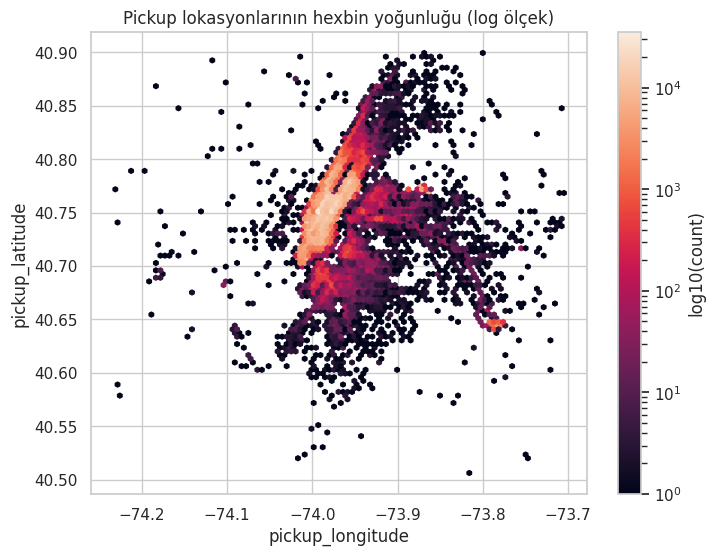

,p_lat_r,p_lon_r,trips,avg_duration_min
6872,40.751,-73.994,8390,14.01
6788,40.750,-73.991,7515,12.96
9063,40.774,-73.873,6143,22.40
6787,40.750,-73.992,5972,12.95
9065,40.774,-73.871,4742,22.44
7454,40.757,-73.990,4202,11.12
7357,40.756,-73.991,3965,11.49
6976,40.752,-73.978,3860,13.26
8461,40.768,-73.982,3535,11.37
6875,40.751,-73.991,3395,11.45


In [ ]:
# ===== Hücre 4: Hızlı hexbin plot + üst 20 nokta için ek ölçütler =====
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.hexbin(df_geo['pickup_longitude'], df_geo['pickup_latitude'], gridsize=100, bins='log')
plt.xlabel('pickup_longitude'); plt.ylabel('pickup_latitude')
plt.title('Pickup lokasyonlarının hexbin yoğunluğu (log ölçek)')
cb = plt.colorbar()
cb.set_label('log10(count)')
plt.show()

# Üst 20 noktayı, yolculuk sayısı ve ortalama süre ile gösterme
hotspots_top20 = hotspots.head(20).copy()
hotspots_top20['avg_duration_min'] = (hotspots_top20['avg_duration_s']/60).round(2)
display(hotspots_top20[['p_lat_r','p_lon_r','trips','avg_duration_min']])



In [ ]:
import os

save_path = "/content/drive/MyDrive/veri_proje/train_clean_final.csv"


os.makedirs(os.path.dirname(save_path), exist_ok=True)


final_df.to_csv(save_path, index=False)

print("Final veri kümesi kaydedildi:")
print(save_path)
print("Boyutu:", final_df.shape)


Final veri kümesi kaydedildi:
/content/drive/MyDrive/veri_proje/train_clean_final.csv
Boyutu: (1447628, 16)


In [ ]:

save_path = "/content/drive/MyDrive/veri_proje/train_clean_final.csv"
final_df.to_csv(save_path, index=False)

print("Final veri kümesi kaydedildi:")
print(save_path)
print("Boyutu:", final_df.shape)



Final veri kümesi kaydedildi:
/content/drive/MyDrive/veri_proje/train_clean_final.csv
Boyutu: (1447628, 16)


### Final Veri Kümesi Kararı

- `df_clean`: 60–7200 saniye süre filtresi, NYC koordinat filtresi ve yolcu sayısı (1–6) filtreleri uygulanmış veri kümesidir.
- `df_no_outliers`: IQR yöntemiyle uç değerleri (outlier) çıkarılmış ek bir versiyondur.

➡ Modelleme için **ana veri kümesi olarak `df_clean` kullanılacaktır**.  
(IQR yalnızca inceleme ve EDA amaçlı kullanılmıştır.)

Diğer grup üyelerinin kullanacağı **final veri kümesi**:

```python
final_df = df_clean.copy()
